In [1]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from datetime import date, timedelta
import time
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [185]:
!pip install sweetviz
import sweetviz as sv

     |████████████████████████████████| 15.1MB 1.4MB/s 
     |████████████████████████████████| 81kB 6.1MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [135]:
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
train_err = pd.read_csv('/content/drive/Shareddrives/dacon/404/train_err2.csv')
train_qui = pd.read_csv('/content/drive/Shareddrives/dacon/404/train_qui2.csv')
train_prob = pd.read_csv('/content/drive/Shareddrives/dacon/404/train_prob2.csv')

test_err = pd.read_csv('/content/drive/Shareddrives/dacon/404/test_err2.csv')
test_qui = pd.read_csv('/content/drive/Shareddrives/dacon/404/test_qui2.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [126]:
train_qui2 = train_qui.copy()
test_qui2 = test_qui.copy()
train_err2 = train_err.copy()
test_err2 = test_err.copy()

# 퀼리티 3,4는 값이 1밖에 없어서 의미가 없기 때문에 제외
# 펌웨어 버전은 이미 err 자료에 있기 때문에 중복으로 제외
# 퀼리티 0은 EDA 결과 퀼리티 2와 피어슨 상관계수 0.99를 보이기 때문에 0과 2 중에 하나만 골랐음
# 0의 결측치 Nan은 15%고 2의 결측치는 4%기 때문에 결측치가 적은 2를 남기고 0은 drop 시킨다.

## 퀼리티 6과 7도 0.81로 강한 상관관계를 보이고 있는데, 하나를 제외해야 하나 고민이 됨
train_qui2.drop(['fwver','quality_0', 'quality_3', 'quality_4'], axis =1, inplace=True)
test_qui2.drop(['fwver', 'quality_0', 'quality_3', 'quality_4'], axis =1, inplace=True)

test_qui2 = test_qui2.replace(',','', regex=True)
train_qui2 = train_qui2.replace(',','', regex=True)
test_qui2.loc[:,'quality_1':'quality_12'] = test_qui2.loc[:,'quality_1':'quality_12'].astype(float)
train_qui2.loc[:,'quality_1':'quality_12'] = train_qui2.loc[:,'quality_1':'quality_12'].astype(float)

train_qui2['time'] = pd.to_datetime(train_qui['time'], format = '%Y-%m-%d %H:%M:%S')
test_qui2['time'] = pd.to_datetime(test_qui['time'], format = '%Y-%m-%d %H:%M:%S')

train_err2['time'] = pd.to_datetime(train_err2['time'], format = '%Y-%m-%d %H:%M:%S')
test_err2['time'] = pd.to_datetime(test_err2['time'], format = '%Y-%m-%d %H:%M:%S')

In [127]:
# 퀼리티 임계치
# [-1, 0, 1] == -1 카테고리 -1, -1~0 =카테고리 0, 그 이상 = 카테고리 1
qualities = {}

qualities['quality_1'] = [-1,0, 1]
qualities['quality_2'] = [-1,0, 1]
qualities['quality_5'] = [-1,0,1,2,4, 10]
qualities['quality_6'] = [-1,0, 1]
qualities['quality_7'] = [0,1,100, 101]
qualities['quality_8'] = [0,1,2]
qualities['quality_9'] = [0,1,2]
qualities['quality_10'] = [0,1,2,3, 4, 5,7, 10 ,14,15] ##??
qualities['quality_11'] = [-1,0,1]
qualities['quality_12'] = [0,1,2]

## 모델 임계치
## 모델 0,1,2,3,4의 비율을 더하면 99.999% 이므로, 모델 5~8은 other model로 통합하는 것이 바람직 해 보임.

In [73]:
import warnings
warnings.filterwarnings(action='ignore')

In [128]:
def quality_categorize(dataset):
  data = dataset.copy()
  for key in tqdm(qualities):
    intervals = qualities.get(key)
    for i in range(len(intervals)):
      if intervals[i] == intervals[-1]:
        data[key][data[key] >= intervals[i]] =  intervals[i]
      # elif intervals[i+1] - intervals[i] == 1:
      #   continue
      else:
        data[key][(data[key] >= intervals[i]) & (data[key] < intervals[i+1])] = intervals[i]
  return data


In [129]:
train_qui3 = quality_categorize(train_qui2)
test_qui3 = quality_categorize(test_qui2)

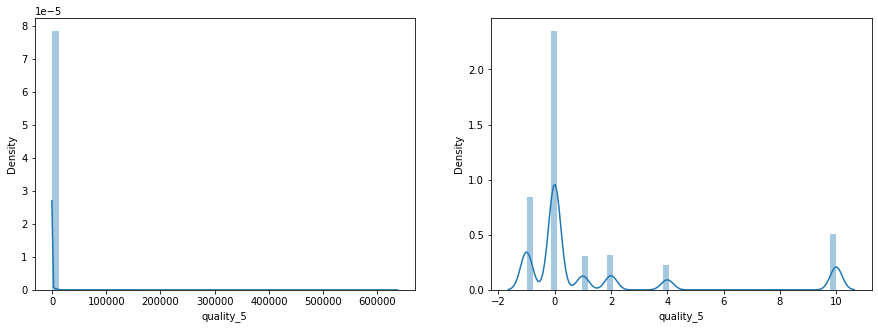

In [149]:
# 왼쪽이 처리 전, 오른쪽이 처리 후

fig, axes = plt.subplots(ncols = 2, figsize=(15, 5))
sns.distplot(train_qui2.quality_5, ax = axes[0])
sns.distplot(train_qui3.quality_5, ax = axes[1])

In [116]:
### 펌웨어/모델넘버 정리하기 ###

# 일단 펌웨어 버전의 분포는 다음과 같다.
train_err2.fwver.value_counts()

# 개인적으로 04.16.3553와 04.16.3517은 큰 차이가 없을 것으로 생각합니다.
# xx.xx가 같다면 뒤에 4자리는 무시하고 합쳐보면 될 듯.

04.16.3553    5237816
04.22.1750    2874213
04.33.1261    2504871
05.15.2138    1906479
03.11.1167    1505659
04.22.1778    1293946
04.33.1185     963736
04.16.3571     145156
04.73.2237      33537
05.66.3237      31832
04.82.1684      23554
04.82.1778       8601
04.22.1684       5554
05.66.3571       3524
04.33.1149       3272
04.73.2571       2527
04.22.1442       2522
03.11.1149       2114
10               1534
04.16.3569        980
04.33.1095        909
05.15.2120        706
04.33.1125        408
04.16.2641        296
8.5.3             212
05.15.3104        191
04.16.3439        142
04.16.3345        101
04.82.1730         78
04.33.1171         58
04.22.1656         39
03.11.1141         29
05.15.2122         23
05.15.2092         18
05.15.2090         12
05.15.2114          9
04.22.1666          5
Name: fwver, dtype: int64

In [161]:
# 펌웨어와 모델간의 관계를 확인한다. (모델_2의 경우)
temp = train_err2[train_err2['model_nm'] == 'model_2']
temp.fwver.value_counts()

04.33.1261    2504871
04.33.1185     963736
04.33.1149       3272
04.33.1095        909
04.33.1125        408
04.33.1171         58
Name: fwver, dtype: int64

In [160]:
# 펌웨어와 모델간의 관계를 확인한다. (모델_3의 경우)
temp = train_err2[train_err2['model_nm'] == 'model_3']
temp.fwver.value_counts()

# 모델 2는 모두 04.33 펌웨어, 모델 3는 모두 05.15 펌웨어임을 알 수 있다.
# 모델 넘버만 있으면 펌웨어는 대충 유추를 할 수 있으므로... 펌웨어는 drop 시키고 모델만 남긴다.

05.15.2138    1906479
05.15.2120        706
05.15.3104        191
05.15.2122         23
05.15.2092         18
05.15.2090         12
05.15.2114          9
Name: fwver, dtype: int64

In [163]:
# 모델 0,1,2,3,4 / 5가지 모델이 차지하는 비중은 99.9% 입니다...
# 따라서 모델 5,6,7,8은 기타 모델로 분류해도 큰 무리가 없을 것이라 생각.... 하지만.. 그래봐야 카테고리 9개 밖에 안되므로 줄이거나 말거나 큰 차이는 없으려나..

train_err2.model_nm.value_counts()

model_1    5384491
model_0    4176279
model_2    3473254
model_3    1907438
model_4    1507802
model_8      36064
model_7      35356
model_5      32233
model_6       1746
Name: model_nm, dtype: int64

In [174]:
### 혹시나 몰라서 펌웨어 날려버리기 전에, 오류 사용자와 정상 사용자의 차이를 비교
# 정상 사용자가 많이 사용하는 모델과 오류 사용자가 많이 사용하는 모델에는 차이가 있는가.
# EDA 결과는 리포트로 구글 드라이브 메인에 저장.

temp =train_err2.drop_duplicates(subset = ['user_id'])
temp = temp[['user_id', 'model_nm', 'fwver']]

In [172]:
prob_list = list(set(train_prob.user_id))

In [177]:
temp['problems'] = temp.user_id.isin(prob_list)

In [180]:
temp_tr = temp[temp['problems']]
temp_fls = temp[temp['problems'] != True]

In [186]:
temp_tr.set_index('user_id', inplace = True)
temp_fls.set_index('user_id', inplace = True)

In [191]:
df = sv.compare(temp_tr, temp_fls)
df.show_html("drive/My Drive/오류이용자_정상이용자_차이비교(모델&펌웨어).html")

In [195]:
# 열어서 확인해보니까... 그냥 펌웨어는 날리고 모델 넘버만 남겨도 좋을 듯 하다.
# 모델은 날리자.

Report drive/My Drive/오류이용자_정상이용자_차이비교(모델&펌웨어).html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [258]:
train_err3 = train_err2[['user_id', 'model_nm', 'errtype', 'errcode', 'time']]
test_err3 = test_err2[['user_id', 'model_nm', 'errtype', 'errcode', 'time']]

In [259]:
# 에러 코드의 분포는 다음과 같다.

print(train_err2.errcode.value_counts())
# 중간에 나오다가 잘리지만.. 전에 발간한 리포트를 보면 상위 15개 에러가 99.9%를 차지하고 있다.
# 따라서 상위 15개는 각각의 카테고리로 주고, 나머지는 16번째 '기타' 카테고리로 묶으면 어떨까 싶습니다.
# 상위 15개 리스트
err_code =['1','0','connection timeout','B-A8002','80','79','14','active','2','84','85','standby','NFANDROID2','connection fail to establish','3']

# 위의 15개에 포함되지 않는 에러코드는 걍 'etc'로 분류
train_err3['errcode'][~train_err3['errcode'].isin(err_code)] = 'ETC'
test_err3['errcode'][~train_err3['errcode'].isin(err_code)] = 'ETC'


## 에러타입은 어차피 41개 뿐이라... 분포도 고른 편 같고... 얌전히 두기로 함.

1                     8906967
0                     2599123
connection timeout    1835600
B-A8002                897863
80                     334018
                       ...   
3376                        1
35065                       1
3843                        1
4166                        1
D-99999                     1
Name: errcode, Length: 2805, dtype: int64


In [234]:
# quality 자료 중에 가장 빈번하게 나온 상위 2개를 뽑아서 return
# q1_1은 퀼리티1에서 가장 자주 나온 에러, q1_2는 2번째로 자주 나온 에러, 없으면 None

freq_list = ['q1_1', 'q1_2','q2_1', 'q2_2','q5_1', 'q5_2','q6_1', 'q6_2','q7_1', 'q7_2','q8_1', 'q8_2','q9_1', 'q9_2','q10_1', 'q10_2','q11_1', 'q11_2','q12_1', 'q12_2',]

def quality_frequency(dataset):
  data = dataset.drop(['time'], axis = 1)
  data = data.fillna(-10)
  frequencies = pd.DataFrame()
  #ids = [10000, 24997]
  ids = list(set(data.user_id.values))
  ids.sort()
  for id in tqdm(ids):
    fre_list = []
    temp = data[data['user_id'] == id]
    for i in range(1,11):
      fre = temp.iloc[1:,i].value_counts()
      one = fre.index[0]
      try:
        two = fre.index[1]
      except:
        two = 'None'  
      fre_list.extend([one, two])
    most = pd.DataFrame(fre_list).transpose()
    frequencies = pd.concat([frequencies, most], axis = 0)
  frequencies.columns = freq_list
  frequencies.index = ids
  return frequencies

In [235]:
# # 에러 코드 중에 어떤 코드가 가장 자주 등장하는가.. 0은 정상으로 보이기 때문에 만약에 0이면 index[1]로 다음 수치를 try


train_qui_frequent = quality_frequency(train_qui3)
test_qui_frequent = quality_frequency(test_qui3)

In [236]:
train_qui_frequent.head(5)

,q1_1,q1_2,q2_1,q2_2,q5_1,q5_2,q6_1,q6_2,q7_1,q7_2,q8_1,q8_2,q9_1,q9_2,q10_1,q10_2,q11_1,q11_2,q12_1,q12_2
10000,0,None,0,None,0,4,0,None,0,None,0,None,0,None,7,4,0,None,0,None
10002,0,-1,0,-1,0,2,0,1,0,1,0,None,0,1,3,5,0,-1,0,None
10004,0,-1,0,-1,0,-1,0,-1,1,0,0,None,0,None,1,3,0,-1,0,None
10005,0,-1,0,-1,-1,0,0,-1,1,0,0,None,0,None,4,5,0,-1,0,None
10006,0,None,0,None,0,4,0,1,0,1,0,None,0,None,4,None,0,None,0,None


In [266]:
# 1일까지 발생한 오류 ~ 2일까지 발생한 오류 ~ 3일까지 ~~~ n일까지 발생한 오류(누적)을 0,1,2,3,4,5 칼럼에 넣어주는 함수
# 퀼리티 로그의 경우 문제가 생기면 문제 이후에 2시간 분량을 수집한다고 했으므로, 몇 번이나 수집되었는지 알면 문제가 몇 번 있었는지도 알 수 있다.
# time에 관한 EDA 결과, 에러코드 수집 시작시간 10월 31일 ~ 11월 30일까지

begins = date(2020, 10, 31).timetuple().tm_yday
ends = date(2020, 11, 30).timetuple().tm_yday

q_list = []
er_list = []
for i in range(31):
  a = 'q_sum_%d'%i
  b = 'er_sum_%d'%i
  q_list.extend([a])
  er_list.extend([b])


def days_sum_quality(data):
    #ids = [10000, 24997]
    ids = list(set(data.user_id.values))
    ids.sort()
    ids_err = list()
    for id in tqdm(ids):
        so_far = 0
        id_err = list()
        dat = data[data['user_id'] == id]
        for days in range(begins, ends + 1):
            # day_errs = data[(data['time'].dt.dayofyear == days) & (data['user_id'] == id)].shape[0]/12
            day_errs = dat[dat['time'].dt.dayofyear == days].shape[0]/12
            so_far += day_errs
            id_err.extend([so_far])
        ids_err.append(id_err)
    err_sums = pd.DataFrame(ids_err, index = ids, columns=q_list)
    return err_sums

In [267]:
train_quality_sum = days_sum_quality(train_qui3)
test_quality_sum = days_sum_quality(test_qui3)

In [268]:
train_quality_sum.head(5)

,q_sum_0,q_sum_1,q_sum_2,q_sum_3,q_sum_4,q_sum_5,q_sum_6,q_sum_7,q_sum_8,q_sum_9,q_sum_10,q_sum_11,q_sum_12,q_sum_13,q_sum_14,q_sum_15,q_sum_16,q_sum_17,q_sum_18,q_sum_19,q_sum_20,q_sum_21,q_sum_22,q_sum_23,q_sum_24,q_sum_25,q_sum_26,q_sum_27,q_sum_28,q_sum_29,q_sum_30
10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
10002,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,8.0
10004,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
10005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
10006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0


In [269]:
# 위에 quality와 동일한 과정인데, err 데이터를 가지고 해 본다.

def days_sum_err(data):
  # ids = [10000, 24998]
  ids = list(set(data.user_id.values))
  ids.sort()
  ids_err = list()
  for id in tqdm(ids):
    so_far = 0
    id_err = list()    
    dat = data[data['user_id'] == id]
    for days in range(begins, ends + 1):
        #day_errs = data[(data['time'].dt.dayofyear == days) & (data['user_id'] == id)].shape[0]
        day_errs = dat[dat['time'].dt.dayofyear == days].shape[0]
        so_far += day_errs
        id_err.extend([so_far])
    ids_err.append(id_err)
  err_sums = pd.DataFrame(ids_err, index = ids, columns=er_list)
  return err_sums

In [270]:
test_err_sum_by_day = days_sum_err(test_err3)
train_err_sum_by_day = days_sum_err(train_err3)

In [271]:
train_err_sum_by_day.head(5)

,er_sum_0,er_sum_1,er_sum_2,er_sum_3,er_sum_4,er_sum_5,er_sum_6,er_sum_7,er_sum_8,er_sum_9,er_sum_10,er_sum_11,er_sum_12,er_sum_13,er_sum_14,er_sum_15,er_sum_16,er_sum_17,er_sum_18,er_sum_19,er_sum_20,er_sum_21,er_sum_22,er_sum_23,er_sum_24,er_sum_25,er_sum_26,er_sum_27,er_sum_28,er_sum_29,er_sum_30
10000,0,11,20,38,43,53,62,82,89,94,104,118,123,140,149,165,174,182,199,218,223,230,235,240,245,254,265,277,295,308,317
10001,0,11,61,90,138,180,209,222,246,299,351,374,413,421,462,486,501,531,556,583,628,653,671,689,716,727,785,2237,2275,2337,2365
10002,0,10,23,36,51,60,68,85,96,108,118,129,140,145,160,173,188,193,202,217,222,232,248,251,257,268,273,289,289,297,306
10003,0,9,23,33,38,54,59,61,72,77,96,120,126,132,134,136,151,157,164,179,184,191,212,223,240,246,254,275,286,300,306
10004,0,25,46,95,123,134,162,180,209,229,283,302,323,340,360,375,390,408,449,457,559,587,603,621,644,671,690,714,732,755,777


In [277]:
# _err 자료에서 errcode를 정리한다.
# 가장 많이 나온 에러코드가 Most, 2번째가 Second

def errcode_sum(data):
    counts = []
    # ids = [10000,24999]
    ids = list(set(data.user_id.values))
    ids.sort()
    
    for id in tqdm(ids):
        err_list = []
        errs = data[data.user_id == id].errcode.value_counts()

        first = errs.index[0]
        try:
            second = errs.index[1]
        except:
            second = 'Nope'

        err_list.extend([first, second]) #, second, third])
        counts.append(err_list)
    frames = pd.DataFrame(counts, columns = ['Most_Err_Code', 'Second_Err_Code'], index = ids)
    return frames

In [278]:
train_err_sum = errcode_sum(train_err3)
test_err_sum = errcode_sum(test_err3)

In [279]:
train_err_sum.head(5)

,Most_Err_Code,Second_Err_Code
10000,1,0
10001,1,standby
10002,1,0
10003,1,0
10004,1,connection timeout


In [291]:
# # _err 자료에서 각 id가 총 몇 번 보고 되었는지 카운트
id_error = train_err3[['user_id','errtype']].values
error = np.zeros((15000,42))
for person_idx, err in tqdm(id_error):
    # person_idx - 10000 위치에 person_idx, errtype에 해당하는 error값을 +1
    error[person_idx - 10000,err - 1] += 1

ind = [i for i in range(10000,25000)]
train_err_type_count = pd.DataFrame(error, index = ind)

id_error = test_err3[['user_id','errtype']].values
error = np.zeros((14999,42))
for person_idx, err in tqdm(id_error):
    # person_idx - 10000 위치에 person_idx, errtype에 해당하는 error값을 +1
    error[person_idx - 30000,err - 1] += 1

ind = [i for i in range(30000,44999)]
test_err_type_count = pd.DataFrame(error, index = ind)

In [293]:
test_err_type_count.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
30000,0.0,0.0,0.0,0.0,62.0,1.0,1.0,0.0,0.0,0.0,16.0,16.0,0.0,3.0,67.0,37.0,9.0,3.0,0.0,1.0,0.0,983.0,1308.0,5.0,2.0,32.0,0.0,0.0,0.0,0.0,83.0,2.0,16.0,0.0,1.0,3.0,3.0,0.0,2.0,92.0,0.0,2.0
30001,0.0,0.0,3.0,98.0,3.0,4.0,4.0,0.0,0.0,0.0,12.0,16.0,4.0,6.0,53.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30002,0.0,0.0,0.0,0.0,79.0,2.0,1.0,0.0,0.0,0.0,16.0,16.0,0.0,1.0,173.0,133.0,0.0,0.0,0.0,0.0,0.0,60.0,40.0,2.0,0.0,40.0,0.0,0.0,0.0,0.0,230.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,14.0,113.0,1.0,2.0
30003,0.0,0.0,0.0,0.0,107.0,2.0,2.0,0.0,0.0,0.0,4.0,5.0,1.0,7.0,8.0,12.0,0.0,1.0,0.0,1.0,0.0,3.0,2.0,0.0,0.0,5.0,2.0,2.0,0.0,0.0,134.0,0.0,4.0,16.0,3.0,1.0,1.0,0.0,0.0,40.0,8.0,0.0
30004,0.0,0.0,0.0,2.0,6.0,1.0,1.0,0.0,0.0,0.0,10.0,12.0,1.0,18.0,80.0,67.0,6.0,0.0,0.0,0.0,0.0,10.0,8.0,0.0,0.0,14.0,1.0,1.0,0.0,0.0,332.0,152.0,11.0,6.0,1.0,1.0,1.0,1.0,0.0,48.0,90.0,0.0


In [294]:
test_err_sum_by_day.to_csv("테스트_에러발생_일일누적합계.csv")
train_err_sum_by_day.to_csv("트레인_에러발생_일일누적합계.csv")

train_quality_sum.to_csv("트레인_퀼리티로그_일일수집합계.csv")
test_quality_sum.to_csv("테스트_퀼리티로그_일일수집합계.csv")

train_err_sum.to_csv("트레인_에러_에러코드별_발생횟수.csv")
test_err_sum.to_csv("테스트_에러_에러코드별_발생횟수.csv")

train_qui_frequent.to_csv("트레인_퀼리티_항목별_많이등장.csv")
test_qui_frequent.to_csv("테스트_퀼리티_항목별_많이등장.csv")

train_err_type_count.to_csv("트레인_에러_42항목별_카운트.csv")
test_err_type_count.to_csv("테스트_에러_42항목별_카운트.csv")

In [295]:
!cp 테스트_에러발생_일일누적합계.csv "drive/My Drive/"
!cp 트레인_에러발생_일일누적합계.csv "drive/My Drive/"
!cp 트레인_퀼리티로그_일일수집합계.csv "drive/My Drive/"
!cp 테스트_퀼리티로그_일일수집합계.csv "drive/My Drive/"
!cp 트레인_에러_에러코드별_발생횟수.csv "drive/My Drive/"
!cp 테스트_에러_에러코드별_발생횟수.csv "drive/My Drive/"
!cp 트레인_퀼리티_항목별_많이등장.csv "drive/My Drive/"
!cp 테스트_퀼리티_항목별_많이등장.csv "drive/My Drive/"
!cp 트레인_에러_42항목별_카운트.csv "drive/My Drive/"
!cp 테스트_에러_42항목별_카운트.csv "drive/My Drive/"